In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import pandas as pd
import skimage.io
from scipy.ndimage import rotate
import cv2
from skimage import filters
import imageio
import skimage
#for the project, start by yourself

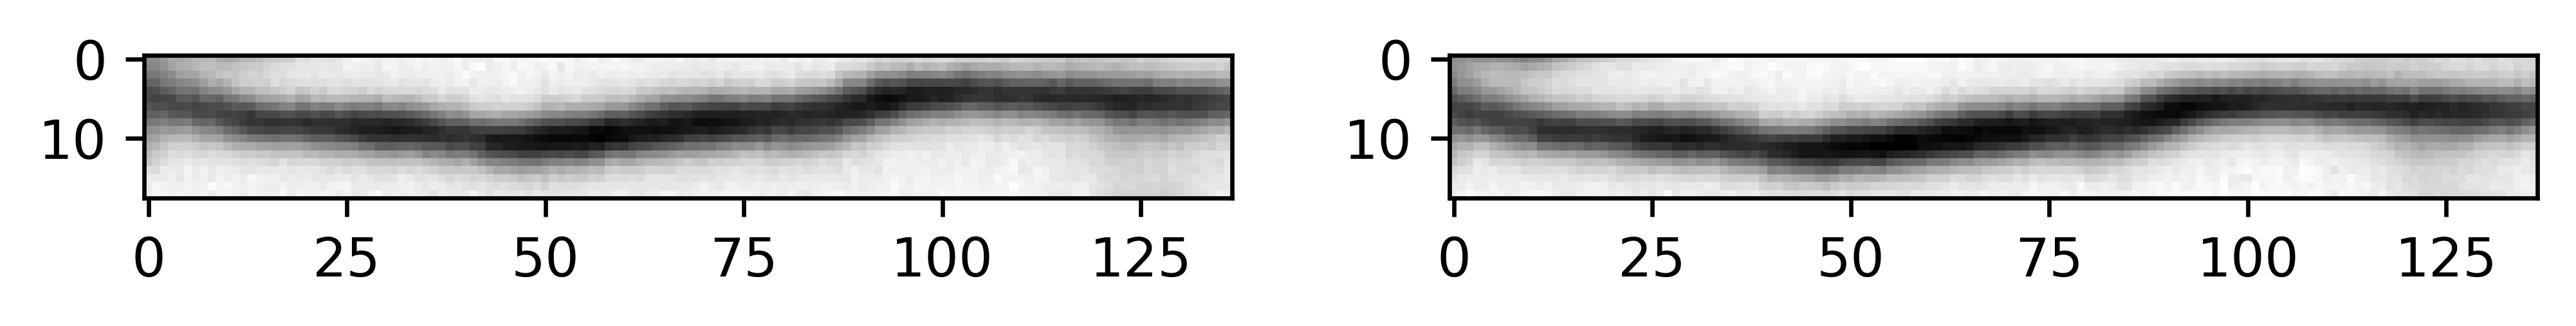

In [291]:
#remove optical density from c+
def OD(chain,empty):
    I=np.mean(chain)
    I0=np.mean(empty)
    OD=np.log(I/I0)
    return OD

fname_cp=r"C:\Users\Mehran\Desktop\Synchrotron&InternationalLabs\Softimax_Nov2023\20230657\2023112308\raw\raw_data\231125\Max_231125093_a.xim"
fname_cn=r"C:\Users\Mehran\Desktop\Synchrotron&InternationalLabs\Softimax_Nov2023\20230657\2023112308\raw\raw_data\231125\Max_231125092_a.xim"


img1=np.array(pd.read_csv(fname_cp,sep='\t'))

# Remove Nans from the arrays and set them to 0
img1[np.isnan(img1)]=0

# Specify the angle of rotation (in degrees)
angle = 5  # Change this value to the desired tilt angle

# Rotate the image by the specified angle
tilted_img1 = rotate(img1, angle, reshape=False)


start_row1, start_col1 = 25, 73
end_row1, end_col1 = start_row1+18, start_col1+137
start_row2, start_col2 = 32, 75
end_row2, end_col2 = start_row2+18, start_col2+137

#start_row1, start_col1 = 41, 90
#end_row1, end_col1 = start_row1+18, start_col1+127
#start_row2, start_col2 = 41, 90
#end_row2, end_col2 = start_row2+18, start_col2+127

# Crop the image using array slicing
img1crop = tilted_img1[start_row1:end_row1, start_col1:end_col1]


#remove optical density from c-
img2=np.array(pd.read_csv(fname_cn,sep='\t'))
img2[np.isnan(img2)]=0
# Crop the image using array slicing
tilted_img2 = rotate(img2, angle, reshape=False)

img2crop = tilted_img2[start_row2:end_row2, start_col2:end_col2]


# convert the image to grayscale
#gray_image1 = skimage.color.rgb2gray(img1)

# blur the image to denoise
blurred_image1 = skimage.filters.gaussian(img1crop, sigma=1)

histogram1, bin_edges = np.histogram(blurred_image1, bins=256, range=(0.0, 100.0))
#histogram2, bin_edges = np.histogram(blurred_image2, bins=256, range=(0.0, 100.0))


# perform automatic thresholding
t1 = skimage.filters.threshold_otsu(blurred_image1)
#print("Found automatic threshold t1 = {}.".format(t1))
# create a binary mask with the threshold found by Otsu's method

binary_mask1 = blurred_image1 < t1
binary_mask1r = blurred_image1 > t1

#----
# convert the image to grayscale
#gray_image1 = skimage.color.rgb2gray(img1)

# blur the image to denoise
blurred_image2 = skimage.filters.gaussian(img2crop, sigma=1)

histogram2, bin_edges = np.histogram(blurred_image2, bins=256, range=(0.0, 100.0))


# perform automatic thresholding
t2 = skimage.filters.threshold_otsu(blurred_image2)
#print("Found automatic threshold t2 = {}.".format(t2))
# create a binary mask with the threshold found by Otsu's method

binary_mask2 = blurred_image2 < t2
binary_mask2r = blurred_image2 > t2


# apply the binary mask to select the foreground
chain1 = img1crop.copy()
chain1[~binary_mask1] = 0
empty1 = img1crop.copy()
empty1[~binary_mask1r] = 0

opde1=OD(chain1, empty1)

#print(opde)

img1crop=img1crop-opde1
#
# apply the binary mask to select the foreground
chain2 = img2crop.copy()
chain2[~binary_mask2] = 0
empty2 = img2crop.copy()
empty2[~binary_mask2r] = 0

opde2=OD(chain2, empty2)

#print(opde2)

img2crop=img2crop-opde2


fig = plt.figure(figsize=(8, 3),dpi=600)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)


ax1.imshow(img1crop, cmap="gray")
ax2.imshow(img2crop, cmap="gray")



shift: [-1.04  0.81]
Mean: 0.00805505330720745
SUM: 19.863761455573574


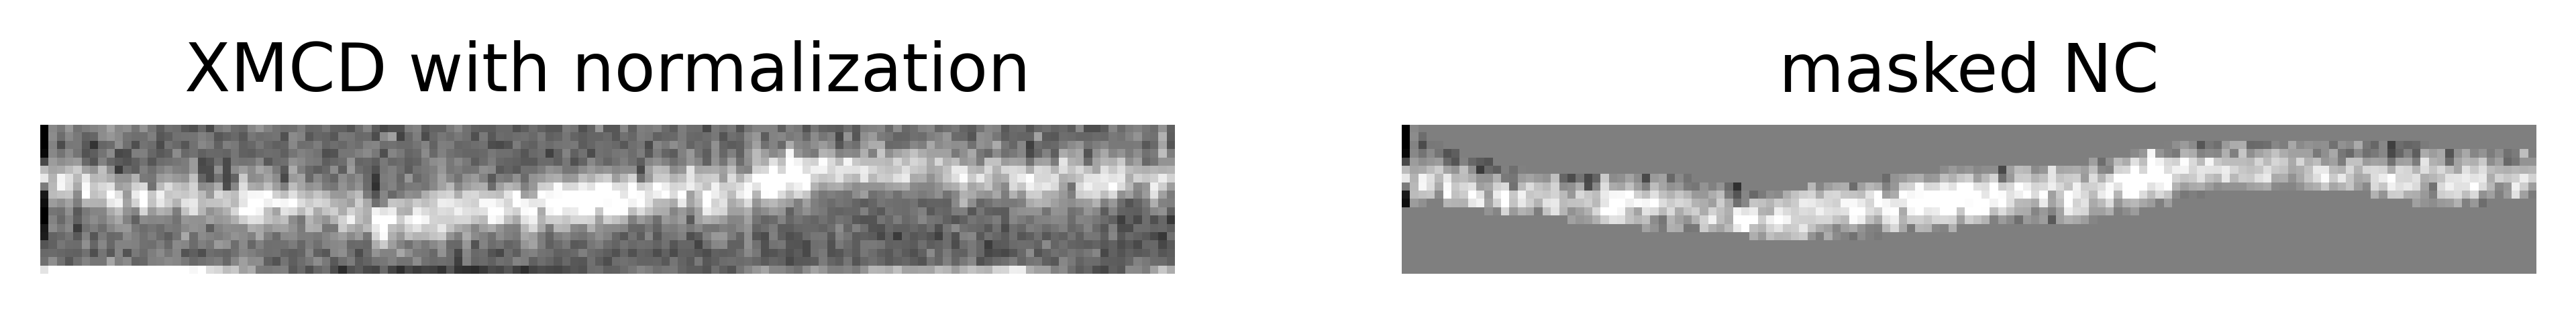

In [292]:
shift, error, diffphase = phase_cross_correlation(img1crop, img2crop ,upsample_factor=100)
shift1 = (0.2, 5.4)
print("shift:" , shift)
offset_img2crop = fourier_shift(np.fft.fftn(img2crop), shift)
offset_img2crop = np.real(np.fft.ifftn(offset_img2crop))

norm=1250

def norm_images(norm,imgcrop):
    I1=norm
    I2=np.median(imgcrop)
    norm_imgcrop=imgcrop*I1/I2
    return norm_imgcrop


norm_img1crop=norm_images(norm,img1crop)
norm_img2crop=norm_images(norm,offset_img2crop)


XMCD = (img1crop-offset_img2crop)#/(selection1+norm_selection2)

XMCD_Normalized = (norm_img1crop-norm_img2crop)/(norm_img1crop+norm_img2crop)
#XMCD_Normalized = (selection1-offset_selection2)/(selection1+offset_selection2)
selection1 = XMCD_Normalized.copy()
selection1[~binary_mask1] = 0


fig = plt.figure(figsize=(8, 3),dpi=600)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
#ax3 = plt.subplot(1, , 3, sharex=ax1, sharey=ax1)
#ax1.imshow(XMCD, cmap='gray', vmin=-50, vmax=300)
#ax1.set_axis_off()
#ax1.set_title('XMCD without normalization')
ax1.imshow(XMCD_Normalized, cmap='gray', vmin = -0.05, vmax = 0.05)
ax1.set_axis_off()
ax1.set_title('XMCD with normalization')
ax2.imshow(selection1, cmap='gray', vmin = -0.05, vmax = 0.05)
ax2.set_axis_off()
ax2.set_title('masked NC')

# Sum up all pixel values in the image
mean = np.mean(selection1)
sumv = np.sum(selection1)

# Now, 'total_sum' contains the sum of all pixel values in the image
print("Mean:", mean)
print("SUM:", sumv)

#print(np.median(norm_img2crop))

Mean: 0.01067548635895799
SUM: 19.87775560037978


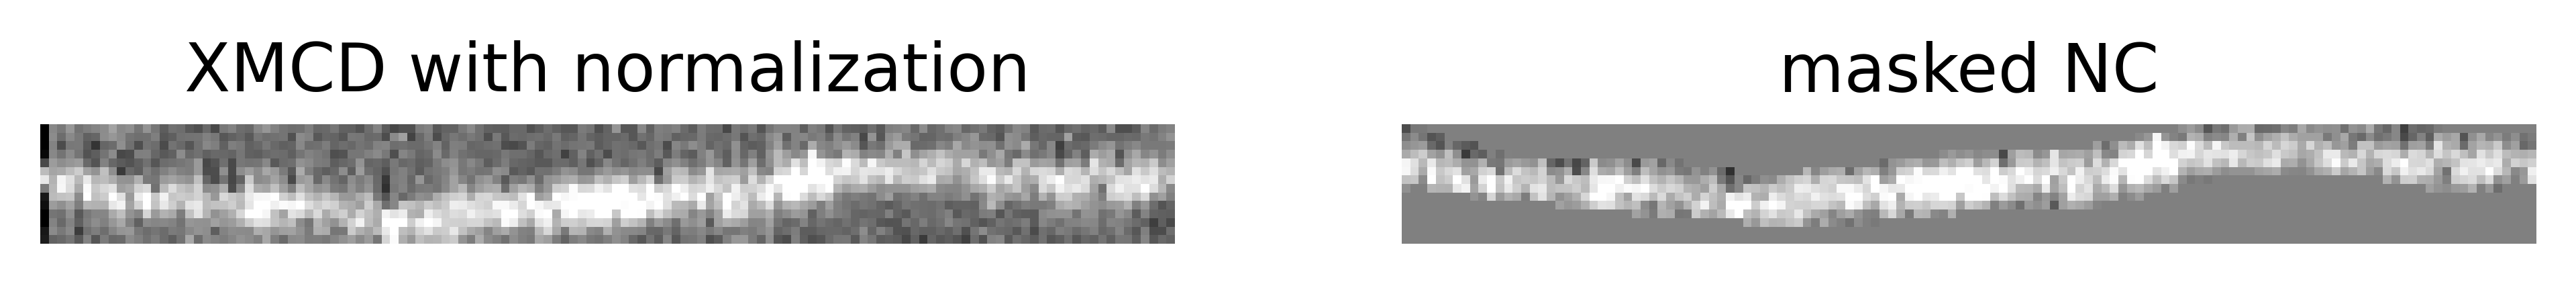

In [293]:
# Specify the thickness of the border to be removed
border_thickness = 2 # Adjust this value based on the thickness of the border

# Remove the border using array slicing
bordermasked = selection1[border_thickness:-border_thickness, border_thickness:-border_thickness]

fig = plt.figure(figsize=(8, 3),dpi=600)
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
#ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1)
#ax1.imshow(XMCD, cmap='gray', vmin=-50, vmax=300)
#ax1.set_axis_off()
#ax1.set_title('XMCD without normalization')
ax1.imshow(XMCD_Normalized, cmap='gray', vmin = -0.05, vmax = 0.05)
ax1.set_axis_off()
ax1.set_title('XMCD with normalization')
ax2.imshow(bordermasked, cmap='gray', vmin = -0.05, vmax = 0.05)
ax2.set_axis_off()
ax2.set_title('masked NC')

mean = np.mean(bordermasked)
sumv = np.sum(bordermasked)
# Now, 'total_sum' contains the sum of all pixel values in the image
print("Mean:", mean)
print("SUM:", sumv)

In [230]:
print(opde2)

-1.0106780185787894


In [87]:
#finish

IndexError: boolean index did not match indexed array along dimension 0; dimension is 239 but corresponding boolean dimension is 20